In [2]:
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, SqrtStretch, PowerStretch
import sunpy.map
import sunpy_soar
from sunpy.net import Fido
import sunpy.net.attrs as a
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import ipywidgets as widgets
from IPython.display import display, clear_output
from tqdm import tqdm
import scipy.ndimage as ndimage
import matplotlib.colors as colors

# Big plots please ...
plt.rcParams['figure.figsize'] = (10, 10)

data_dir = '/home/mnedal/data'

In [3]:
sunpy.__version__

'7.0.0'

In [12]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import re

BASE_URL = 'https://www.sidc.be/EUI/data/L2/'

def list_directory(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        links = [a['href'] for a in soup.find_all('a', href=True)]
        # Skip parent directory links and only return folders
        return [link.strip('/') for link in links if link.endswith('/') and not link.startswith('?')]
    except Exception as e:
        print(f'Error accessing {url}: {e}')
        return []

def extract_datetime_from_filename(filename):
    match = re.search(r'_(\d{8}T\d{9})_', filename)
    if match:
        dt_str = match.group(1)
        dt = datetime.strptime(dt_str, '%Y%m%dT%H%M%S%f')
        return dt.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]  # Truncate to milliseconds
    return None

In [13]:
# Crawl the directory structure
years = list_directory(BASE_URL)

In [14]:
years

['EUI/data', '2020', '2021', '2022', '2023', '2024', '2025']

In [15]:
months

['Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec']

In [16]:
np.array(days)

NameError: name 'days' is not defined

In [207]:
year_url

'https://www.sidc.be/EUI/data/L2/2021/'

In [209]:
month_url

'https://www.sidc.be/EUI/data/L2/2021/02/'

In [211]:
day_url

'https://www.sidc.be/EUI/data/L2/2021/02/22/'

In [17]:
hri_timestamps = {}

for year in years:
    year_url = f'{BASE_URL}{year}/'
    months = list_directory(year_url)
    for month in months:
        month_url = f'{year_url}{month}/'
        days = list_directory(month_url)
        for day in days:
            day_url = f'{month_url}{day}/'
            try:
                response = requests.get(day_url)
                response.raise_for_status()
                soup = BeautifulSoup(response.text, 'html.parser')
                fits_files = [a['href'] for a in soup.find_all('a', href=True) if a['href'].endswith('.fits')]
                for file in fits_files:
                    if 'hrieuv' in file.lower():
                        timestamp = extract_datetime_from_filename(file)
                        if timestamp:
                            hri_timestamps[file] = timestamp
            except Exception as e:
                print(f'Failed to process {day_url}: {e}')

Error accessing https://www.sidc.be/EUI/data/L2/EUI/data/: 404 Client Error: Not Found for url: https://www.sidc.be/EUI/data/L2/EUI/data/
Error accessing https://www.sidc.be/EUI/data/L2/2020/EUI/data/L2/: 404 Client Error: Not Found for url: https://www.sidc.be/EUI/data/L2/2020/EUI/data/L2/
Failed to process https://www.sidc.be/EUI/data/L2/2020/05/EUI/data/L2/2020/: 404 Client Error: Not Found for url: https://www.sidc.be/EUI/data/L2/2020/05/EUI/data/L2/2020/
Failed to process https://www.sidc.be/EUI/data/L2/2020/06/EUI/data/L2/2020/: 404 Client Error: Not Found for url: https://www.sidc.be/EUI/data/L2/2020/06/EUI/data/L2/2020/
Failed to process https://www.sidc.be/EUI/data/L2/2020/08/EUI/data/L2/2020/: 404 Client Error: Not Found for url: https://www.sidc.be/EUI/data/L2/2020/08/EUI/data/L2/2020/
Failed to process https://www.sidc.be/EUI/data/L2/2020/10/EUI/data/L2/2020/: 404 Client Error: Not Found for url: https://www.sidc.be/EUI/data/L2/2020/10/EUI/data/L2/2020/
Failed to process ht


KeyboardInterrupt



In [246]:
hri_timestamps_list = list(hri_timestamps.items())[:10]  # Show sample
hri_timestamps_list

[('solo_L2_eui-hrieuv174-image_20200512T125014704_V06.fits',
  '2020-05-12 12:50:14.704'),
 ('solo_L2_eui-hrieuv174-image_20200512T125024830_V06.fits',
  '2020-05-12 12:50:24.830'),
 ('solo_L2_eui-hrieuv174-image_20200512T131056335_V06.fits',
  '2020-05-12 13:10:56.335'),
 ('solo_L2_eui-hrieuv174-image_20200512T131106457_V06.fits',
  '2020-05-12 13:11:06.457'),
 ('solo_L2_eui-hrieuvopn-image_20200512T122556952_V06.fits',
  '2020-05-12 12:25:56.952'),
 ('solo_L2_eui-hrieuvopn-image_20200512T122606952_V06.fits',
  '2020-05-12 12:26:06.952'),
 ('solo_L2_eui-hrieuvopn-image_20200512T131608957_V06.fits',
  '2020-05-12 13:16:08.957'),
 ('solo_L2_eui-hrieuvopn-image_20200512T131618957_V06.fits',
  '2020-05-12 13:16:18.957'),
 ('solo_L2_eui-hrieuvopn-image_20200512T131629082_V06.fits',
  '2020-05-12 13:16:29.082'),
 ('solo_L2_eui-hrieuvopn-image_20200512T131639083_V06.fits',
  '2020-05-12 13:16:39.083')]

In [244]:
# import pickle


# with open(f'{data_dir}/pkl_files/hri_timestamps.pkl', 'wb') as f:
#     pickle.dump(hri_timestamps, f)

In [ ]:
# import csv

# with open(f'{data_dir}/csv_files/hri_timestamps.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(['filename', 'timestamp'])
#     for fname, ts in hri_timestamps.items():
#         writer.writerow([fname, ts])

## Choose a certain time range to fetch the maps

In [22]:
import pandas as pd

# df = pd.read_csv(f'{data_dir}/csv_files/hri_timestamps.csv')

dict = pd.read_pickle(f'{data_dir}/pkl_files/hri_timestamps.pkl')
df = pd.DataFrame(list(dict.items()), columns=['filename', 'timestamp'])
df

filename  \
0       solo_L2_eui-hrieuv174-image_20200512T125014704...   
1       solo_L2_eui-hrieuv174-image_20200512T125024830...   
2       solo_L2_eui-hrieuv174-image_20200512T131056335...   
3       solo_L2_eui-hrieuv174-image_20200512T131106457...   
4       solo_L2_eui-hrieuvopn-image_20200512T122556952...   
...                                                   ...   
248060  solo_L2_eui-hrieuvopn-image_20250119T212825251...   
248061  solo_L2_eui-hrieuvopn-image_20250119T213221237...   
248062  solo_L2_eui-hrieuvopn-image_20250119T213225490...   
248063  solo_L2_eui-hrieuvopn-image_20250119T213621249...   
248064  solo_L2_eui-hrieuvopn-image_20250119T213625239...   

                      timestamp  
0       2020-05-12 12:50:14.704  
1       2020-05-12 12:50:24.830  
2       2020-05-12 13:10:56.335  
3       2020-05-12 13:11:06.457  
4       2020-05-12 12:25:56.952  
...                         ...  
248060  2025-01-19 21:28:25.251  
248061  2025-01-19 21:32:21.237  
248062  2025-01-19 21:32:25.490  
248063  2025-01-19 21:36:21.249  
248064  2025-01-19 21:36:25.239  

[248065 rows x 2 columns]

In [23]:
df['timestamp'].iloc[0], df['timestamp'].iloc[-1]

('2020-05-12 12:50:14.704', '2025-01-19 21:36:25.239')

## Data coverage diagnostics - Data availability

2025-07-23 16:36:06 - matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-23 16:36:06 - matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-23 16:36:06 - matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-23 16:36:06 - matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


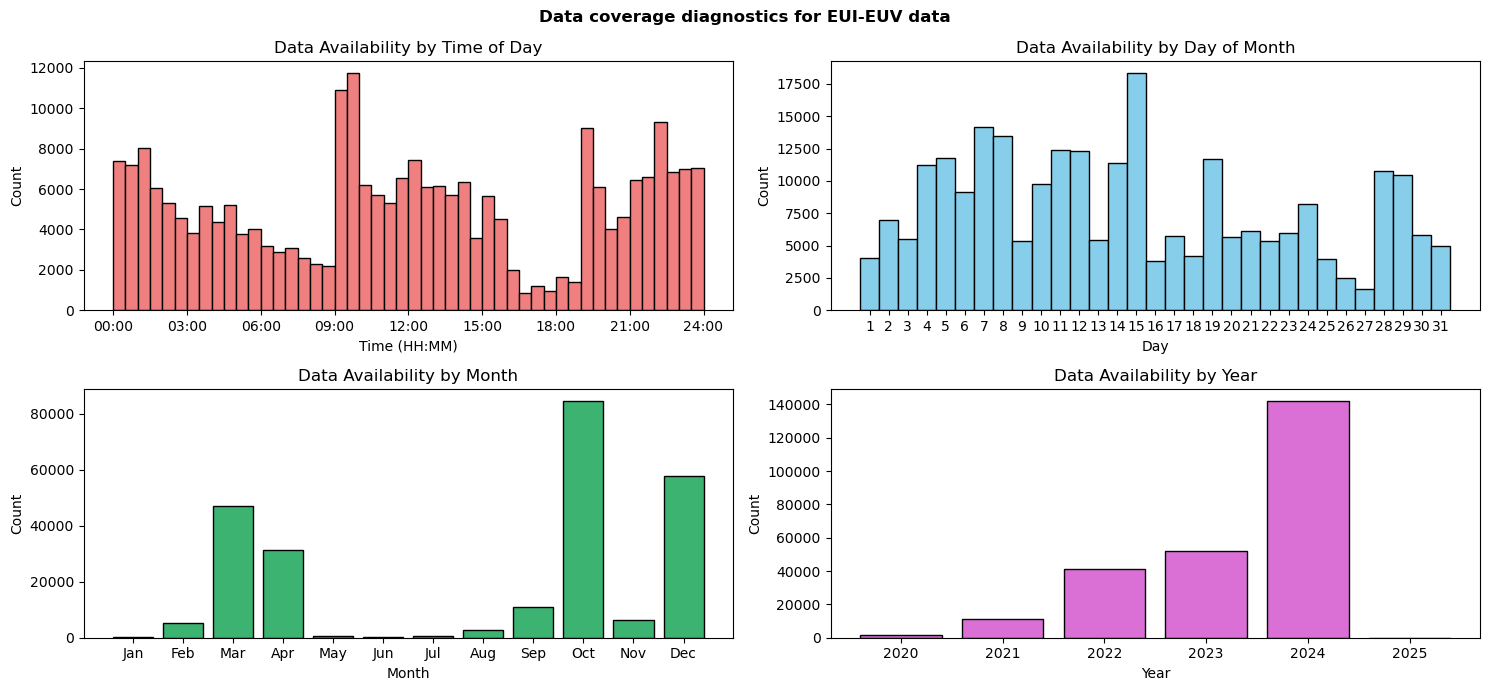

In [24]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Convert timestamp column
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract time of day (without date)
df['time_of_day'] = df['timestamp'].dt.time
df['time_float'] = df['timestamp'].dt.hour + df['timestamp'].dt.minute/60 + df['timestamp'].dt.second/3600

# Extract day, month, year
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['month_name'] = df['timestamp'].dt.month_name().str[:3]  # Jan, Feb, ...
df['year'] = df['timestamp'].dt.year

fig, axs = plt.subplots(2, 2, figsize=[15,7])
fig.suptitle('Data coverage diagnostics for EUI-EUV data', fontweight='bold')

# --- Plot 1: Time of Day (x-axis = HH:MM:SS)
axs[0, 0].hist(df['time_float'], bins=48, color='lightcoral', edgecolor='k')
axs[0, 0].set_xticks(range(0, 25, 3))
axs[0, 0].set_xticklabels([f'{h:02d}:00' for h in range(0, 25, 3)])
axs[0, 0].set_title('Data Availability by Time of Day')
axs[0, 0].set_xlabel('Time (HH:MM)')
axs[0, 0].set_ylabel('Count')

# --- Plot 2: Day of Month
axs[0, 1].hist(df['day'], bins=range(1, 33), color='skyblue', edgecolor='k', align='left')
axs[0, 1].set_xticks(range(1, 32))
axs[0, 1].set_title('Data Availability by Day of Month')
axs[0, 1].set_xlabel('Day')
axs[0, 1].set_ylabel('Count')

# --- Plot 3: Month
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_counts = df['month_name'].value_counts().reindex(months)
axs[1, 0].bar(month_counts.index, month_counts.values, color='mediumseagreen', edgecolor='k')
axs[1, 0].set_title('Data Availability by Month')
axs[1, 0].set_xlabel('Month')
axs[1, 0].set_ylabel('Count')

# --- Plot 4: Year
year_counts = df['year'].value_counts().sort_index()
axs[1, 1].bar(year_counts.index.astype(str), year_counts.values, color='orchid', edgecolor='k')
axs[1, 1].set_title('Data Availability by Year')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## Filter by a specific date

In [65]:
day = '2024-03-10'

files_on_day = df[df['timestamp'].dt.date == pd.to_datetime(day).date()]
files_on_day.head(50)

filename  \
107156  solo_L2_eui-hrieuv174-image_20240310T000816271...   
107157  solo_L2_eui-hrieuv174-image_20240310T000846271...   
107158  solo_L2_eui-hrieuv174-image_20240310T000916270...   
107159  solo_L2_eui-hrieuv174-image_20240310T001816272...   
107160  solo_L2_eui-hrieuv174-image_20240310T001846272...   
107161  solo_L2_eui-hrieuv174-image_20240310T001916272...   
107162  solo_L2_eui-hrieuv174-image_20240310T002816274...   
107163  solo_L2_eui-hrieuv174-image_20240310T002846273...   
107164  solo_L2_eui-hrieuv174-image_20240310T002916273...   
107165  solo_L2_eui-hrieuv174-image_20240310T003816274...   
107166  solo_L2_eui-hrieuv174-image_20240310T003846274...   
107167  solo_L2_eui-hrieuv174-image_20240310T003916274...   
107168  solo_L2_eui-hrieuv174-image_20240310T004816275...   
107169  solo_L2_eui-hrieuv174-image_20240310T004846275...   
107170  solo_L2_eui-hrieuv174-image_20240310T004916275...   
107171  solo_L2_eui-hrieuv174-image_20240310T005816276...   
107172  solo_L2_eui-hrieuv174-image_20240310T005846276...   
107173  solo_L2_eui-hrieuv174-image_20240310T005916277...   
107174  solo_L2_eui-hrieuv174-image_20240310T010816277...   
107175  solo_L2_eui-hrieuv174-image_20240310T010846277...   
107176  solo_L2_eui-hrieuv174-image_20240310T010916278...   
107177  solo_L2_eui-hrieuv174-image_20240310T011816279...   
107178  solo_L2_eui-hrieuv174-image_20240310T011846278...   
107179  solo_L2_eui-hrieuv174-image_20240310T011916279...   
107180  solo_L2_eui-hrieuv174-image_20240310T012816280...   
107181  solo_L2_eui-hrieuv174-image_20240310T012846279...   
107182  solo_L2_eui-hrieuv174-image_20240310T012916280...   
107183  solo_L2_eui-hrieuv174-image_20240310T013816281...   
107184  solo_L2_eui-hrieuv174-image_20240310T013846281...   
107185  solo_L2_eui-hrieuv174-image_20240310T013916281...   
107186  solo_L2_eui-hrieuv174-image_20240310T014816282...   
107187  solo_L2_eui-hrieuv174-image_20240310T014846282...   
107188  solo_L2_eui-hrieuv174-image_20240310T014916282...   
107189  solo_L2_eui-hrieuv174-image_20240310T015816283...   
107190  solo_L2_eui-hrieuv174-image_20240310T015846283...   
107191  solo_L2_eui-hrieuv174-image_20240310T015916283...   
107192  solo_L2_eui-hrieuv174-image_20240310T020816283...   
107193  solo_L2_eui-hrieuv174-image_20240310T020846285...   
107194  solo_L2_eui-hrieuv174-image_20240310T020916284...   
107195  solo_L2_eui-hrieuv174-image_20240310T021816285...   
107196  solo_L2_eui-hrieuv174-image_20240310T021846285...   
107197  solo_L2_eui-hrieuv174-image_20240310T021916285...   
107198  solo_L2_eui-hrieuv174-image_20240310T022816287...   
107199  solo_L2_eui-hrieuv174-image_20240310T022846286...   
107200  solo_L2_eui-hrieuv174-image_20240310T022916286...   
107201  solo_L2_eui-hrieuv174-image_20240310T023816287...   
107202  solo_L2_eui-hrieuv174-image_20240310T023846287...   
107203  solo_L2_eui-hrieuv174-image_20240310T023916287...   
107204  solo_L2_eui-hrieuv174-image_20240310T024816288...   
107205  solo_L2_eui-hrieuv174-image_20240310T024846289...   

                     timestamp      time_of_day  time_float  day  month  \
107156 2024-03-10 00:08:16.271  00:08:16.271000    0.137778   10      3   
107157 2024-03-10 00:08:46.271  00:08:46.271000    0.146111   10      3   
107158 2024-03-10 00:09:16.270  00:09:16.270000    0.154444   10      3   
107159 2024-03-10 00:18:16.272  00:18:16.272000    0.304444   10      3   
107160 2024-03-10 00:18:46.272  00:18:46.272000    0.312778   10      3   
107161 2024-03-10 00:19:16.272  00:19:16.272000    0.321111   10      3   
107162 2024-03-10 00:28:16.274  00:28:16.274000    0.471111   10      3   
107163 2024-03-10 00:28:46.273  00:28:46.273000    0.479444   10      3   
107164 2024-03-10 00:29:16.273  00:29:16.273000    0.487778   10      3   
107165 2024-03-10 00:38:16.274  00:38:16.274000    0.637778   10      3   
107166 2024-03-10 00:38:46.274  00:38:46.274000    0.646111   10      3   
107167 2024-03-10 00:39:16.274  00:39

/tmp/ipykernel_2014251/497283165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files_on_day['hour_float'] = files_on_day['timestamp'].dt.time.apply(time_to_hour)


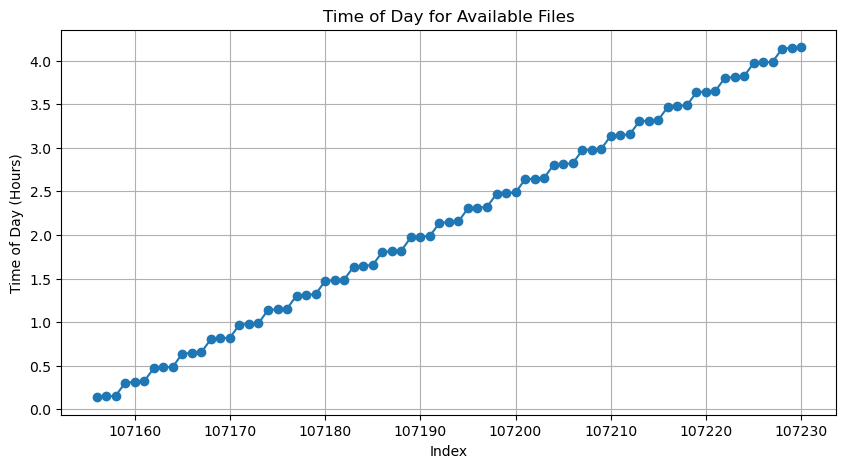

In [26]:
def time_to_hour(t):
    return t.hour + t.minute / 60 + t.second / 3600

files_on_day['hour_float'] = files_on_day['timestamp'].dt.time.apply(time_to_hour)

plt.figure(figsize=[10,5])
plt.plot(files_on_day['hour_float'], marker='o')
plt.xlabel('Index')
plt.ylabel('Time of Day (Hours)')
plt.title('Time of Day for Available Files')
plt.grid(True)
plt.show()

## Check for multiple days

In [27]:
days = ['2023-09-21', '2024-03-10', '2024-04-24', '2024-07-04', '2024-09-14']

for day in days:
    print(day)
    files_on_day = df[df['timestamp'].dt.date == pd.to_datetime(day).date()]
    display(files_on_day)
    print('=================================================================')

2023-09-21


Empty DataFrame
Columns: [filename, timestamp, time_of_day, time_float, day, month, month_name, year]
Index: []

2024-03-10


filename  \
107156  solo_L2_eui-hrieuv174-image_20240310T000816271...   
107157  solo_L2_eui-hrieuv174-image_20240310T000846271...   
107158  solo_L2_eui-hrieuv174-image_20240310T000916270...   
107159  solo_L2_eui-hrieuv174-image_20240310T001816272...   
107160  solo_L2_eui-hrieuv174-image_20240310T001846272...   
...                                                   ...   
107226  solo_L2_eui-hrieuv174-image_20240310T035846296...   
107227  solo_L2_eui-hrieuv174-image_20240310T035916295...   
107228  solo_L2_eui-hrieuv174-image_20240310T040816328...   
107229  solo_L2_eui-hrieuv174-image_20240310T040846298...   
107230  solo_L2_eui-hrieuv174-image_20240310T040916297...   

                     timestamp      time_of_day  time_float  day  month  \
107156 2024-03-10 00:08:16.271  00:08:16.271000    0.137778   10      3   
107157 2024-03-10 00:08:46.271  00:08:46.271000    0.146111   10      3   
107158 2024-03-10 00:09:16.270  00:09:16.270000    0.154444   10      3   
107159 2024-03-10 00:18:16.272  00:18:16.272000    0.304444   10      3   
107160 2024-03-10 00:18:46.272  00:18:46.272000    0.312778   10      3   
...                        ...              ...         ...  ...    ...   
107226 2024-03-10 03:58:46.296  03:58:46.296000    3.979444   10      3   
107227 2024-03-10 03:59:16.295  03:59:16.295000    3.987778   10      3   
107228 2024-03-10 04:08:16.328  04:08:16.328000    4.137778   10      3   
107229 2024-03-10 04:08:46.298  04:08:46.298000    4.146111   10      3   
107230 2024-03-10 04:09:16.297  04:09:16.297000    4.154444   10      3   

       month_name  year  
107156        Mar  2024  
107157        Mar  2024  
107158        Mar  2024  
107159        Mar  2024  
107160        Mar  2024  
...           ...   ...  
107226        Mar  2024  
107227        Mar  2024  
107228        Mar  2024  
107229        Mar  2024  
107230        Mar  2024  

[75 rows x 8 columns]

2024-04-24


Empty DataFrame
Columns: [filename, timestamp, time_of_day, time_float, day, month, month_name, year]
Index: []

2024-07-04


Empty DataFrame
Columns: [filename, timestamp, time_of_day, time_float, day, month, month_name, year]
Index: []

2024-09-14


Empty DataFrame
Columns: [filename, timestamp, time_of_day, time_float, day, month, month_name, year]
Index: []

In [28]:
# Filter by a time range
start = pd.to_datetime('2024-03-10 03:50:00')
end   = pd.to_datetime('2024-03-10 04:00:00')

files_in_window = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]
files_in_window

filename  \
107225  solo_L2_eui-hrieuv174-image_20240310T035816296...   
107226  solo_L2_eui-hrieuv174-image_20240310T035846296...   
107227  solo_L2_eui-hrieuv174-image_20240310T035916295...   

                     timestamp      time_of_day  time_float  day  month  \
107225 2024-03-10 03:58:16.296  03:58:16.296000    3.971111   10      3   
107226 2024-03-10 03:58:46.296  03:58:46.296000    3.979444   10      3   
107227 2024-03-10 03:59:16.295  03:59:16.295000    3.987778   10      3   

       month_name  year  
107225        Mar  2024  
107226        Mar  2024  
107227        Mar  2024

## Inspect the HRI EUV maps

In [45]:
start, end

(Timestamp('2024-03-10 03:50:00'), Timestamp('2024-03-10 04:00:00'))

In [29]:
instrument = a.Instrument('EUI')
level      = a.Level(2)
time       = a.Time(start, end)
product    = a.soar.Product('EUI-HRIEUV174-IMAGE')
result     = Fido.search(instrument & time & level & product)
display(result)

<sunpy.net.fido_factory.UnifiedResponse object at 0x7216e196e3f0>
Results from 1 Provider:

3 Results from the SOARClient:

Instrument     Data product    Level        Start time               End time        Filesize                               SOOP Name                               Detector Wavelength
                                                                                      Mbyte                                                                                            
---------- ------------------- ----- ----------------------- ----------------------- -------- --------------------------------------------------------------------- -------- ----------
       EUI eui-hrieuv174-image    L2 2024-03-10 03:58:16.296 2024-03-10 03:58:19.096     5.42 R_FULL_LRES_LCAD_RS-Synoptics-High;R_SMALL_HRES_MCAD_Full-Disk-Mosaic  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 2024-03-10 03:58:46.296 2024-03-10 03:58:49.096    5.155 R_FULL_LRES_LCAD_RS-Synoptics-High;R_SMALL_HRES_MCAD_Full-Disk-Mosaic  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 2024-03-10 03:59:16.295 2024-03-10 03:59:19.095    5.147 R_FULL_LRES_LCAD_RS-Synoptics-High;R_SMALL_HRES_MCAD_Full-Disk-Mosaic  HRI_EUV      174.0

In [30]:
eui_files = Fido.fetch(result, path='/home/mnedal/data/SOLO/EUI/')

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

In [31]:
eui_sequence = sunpy.map.Map(eui_files, sequence=True)
print(len(eui_sequence))

3


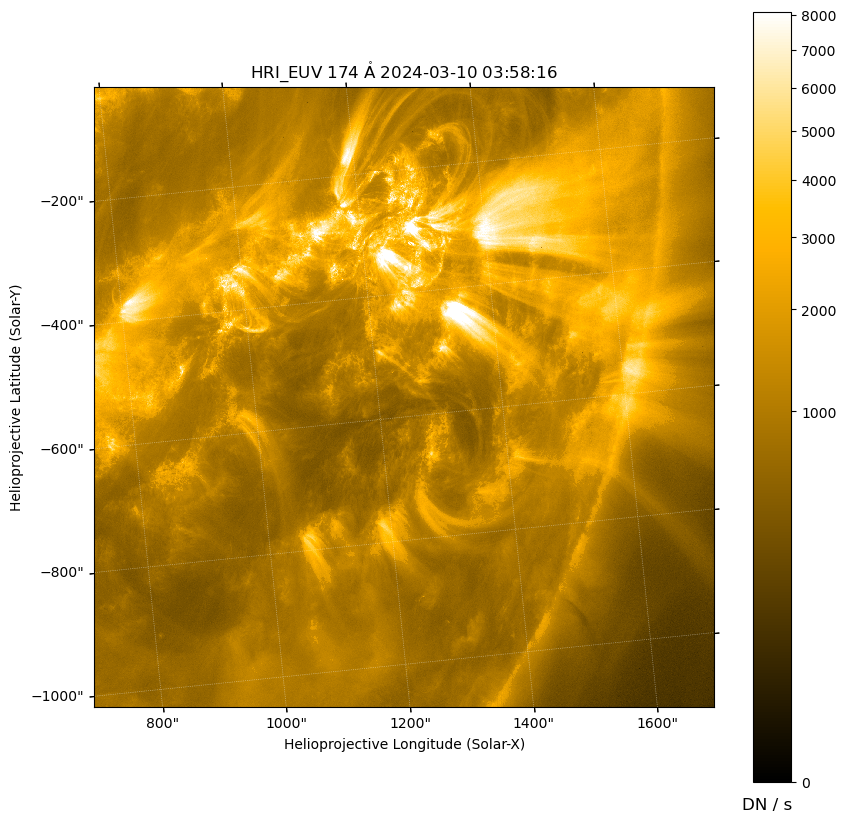

In [32]:
eui_map = eui_sequence[0]
# eui_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=2000, stretch=SqrtStretch())
eui_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=np.nanpercentile(eui_map.data,99.8), stretch=PowerStretch(0.35))
eui_map.peek()

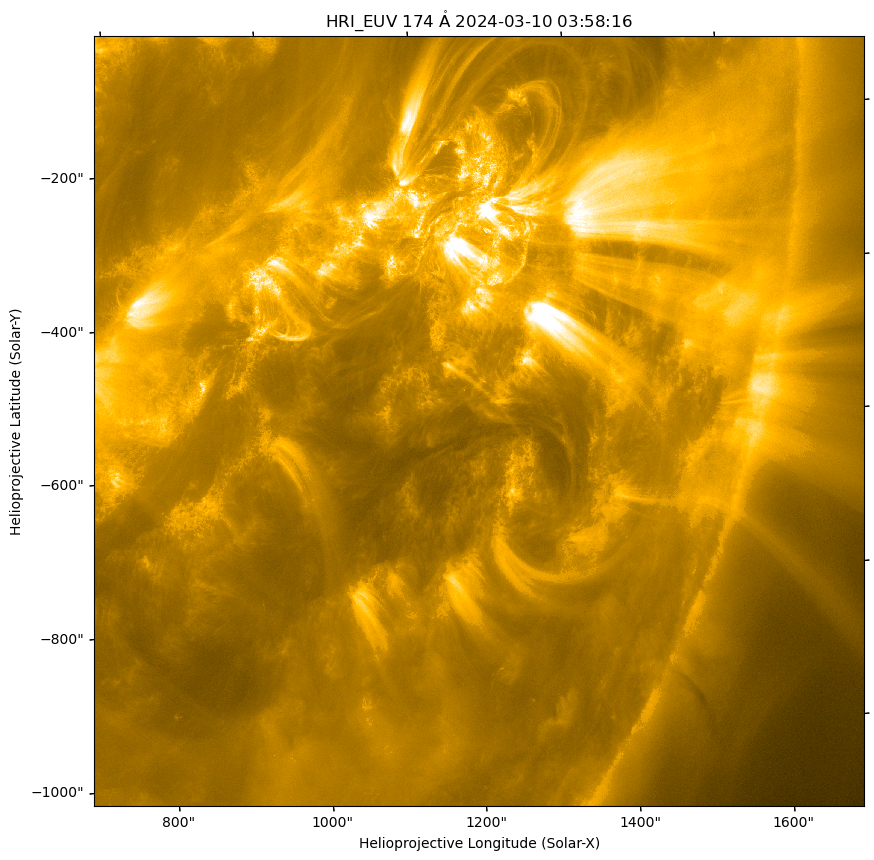

In [63]:
# Plot them together
fig, ax = plt.subplots(subplot_kw={'projection': eui_map})
eui_map.plot(axes=ax)
ax.grid(False)
plt.show()

## Download AIA data for the same time and project EUI on it

In [34]:
channel    = 171
instrument = a.Instrument('AIA')
time       = a.Time(start, end)
wavelength = a.Wavelength(channel*u.angstrom)
cadence    = a.Sample(1*u.minute)
result     = Fido.search(instrument & time & wavelength & cadence)
display(result)

<sunpy.net.fido_factory.UnifiedResponse object at 0x7216d3a0e8d0>
Results from 1 Provider:

10 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search
Data retrieval status: https://docs.virtualsolar.org/wiki/VSOHealthReport
Total estimated size: 677.888 Mbyte

       Start Time               End Time        Source Instrument   Wavelength   Provider  Physobs  Wavetype Extent Width Extent Length Extent Type   Size  
                                                                     Angstrom                                                                        Mibyte 
----------------------- ----------------------- ------ ---------- -------------- -------- --------- -------- ------------ ------------- ----------- --------
2024-03-10 03:50:09.000 2024-03-10 03:50:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2024-03-10 03:51:09.000 2024-03-10 03:51:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2024-03-10 03:52:09.000 2024-03-10 03:52:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2024-03-10 03:53:09.000 2024-03-10 03:53:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2024-03-10 03:54:09.000 2024-03-10 03:54:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2024-03-10 03:55:09.000 2024-03-10 03:55:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2024-03-10 03:56:09.000 2024-03-10 03:56:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2024-03-10 03:57:09.000 2024-03-10 03:57:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2024-03-10 03:58:09.000 2024-03-10 03:58:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2024-03-10 03:59:09.000 2024-03-10 03:59:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844

In [20]:
aia_files = Fido.fetch(result, path=f'/home/mnedal/data/AIA/{channel}A/')

Files Downloaded:   0%|          | 0/10 [00:00<?, ?file/s]

2025-07-23 13:00:15 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=171_1489117847-1489117847 failed to download with exception
Timeout on reading data from socket
2025-07-23 13:00:15 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=171_1489117907-1489117907 failed to download with exception
Timeout on reading data from socket
2025-07-23 13:00:15 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=171_1489117967-1489117967 failed to download with exception
Timeout on reading data from socket
2025-07-23 13:00:15 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=171_1489118027-1489118027 failed to download with exception
Timeout on reading data from socket
2025-07-23 13:00:15 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=ai

10/0 files failed to download. Please check `.errors` for details


In [35]:
import glob

aia_files = glob.glob(f'/home/mnedal/data/AIA/{channel}A/*.fits')
aia_files

['/home/mnedal/data/AIA/171A/aia.lev1.171A_2024_03_10T03_55_09.34Z.image_lev1.fits',
 '/home/mnedal/data/AIA/171A/aia.lev1.171A_2024_03_10T03_54_09.35Z.image_lev1.fits',
 '/home/mnedal/data/AIA/171A/aia.lev1.171A_2024_03_10T03_56_09.35Z.image_lev1.fits',
 '/home/mnedal/data/AIA/171A/aia.lev1.171A_2024_03_10T03_57_09.34Z.image_lev1.fits',
 '/home/mnedal/data/AIA/171A/aia.lev1.171A_2024_03_10T03_58_09.35Z.image_lev1.fits',
 '/home/mnedal/data/AIA/171A/aia.lev1.171A_2024_03_10T03_53_09.34Z.image_lev1.fits',
 '/home/mnedal/data/AIA/171A/aia.lev1.171A_2024_03_10T03_52_09.35Z.image_lev1.fits',
 '/home/mnedal/data/AIA/171A/aia.lev1.171A_2024_03_10T03_59_09.35Z.image_lev1.fits',
 '/home/mnedal/data/AIA/171A/aia.lev1.171A_2024_03_10T03_50_09.35Z.image_lev1.fits',
 '/home/mnedal/data/AIA/171A/aia.lev1.171A_2024_03_10T03_51_09.35Z.image_lev1.fits']

In [36]:
aia_sequence = sunpy.map.Map(aia_files, sequence=True)
print(len(aia_sequence))

10


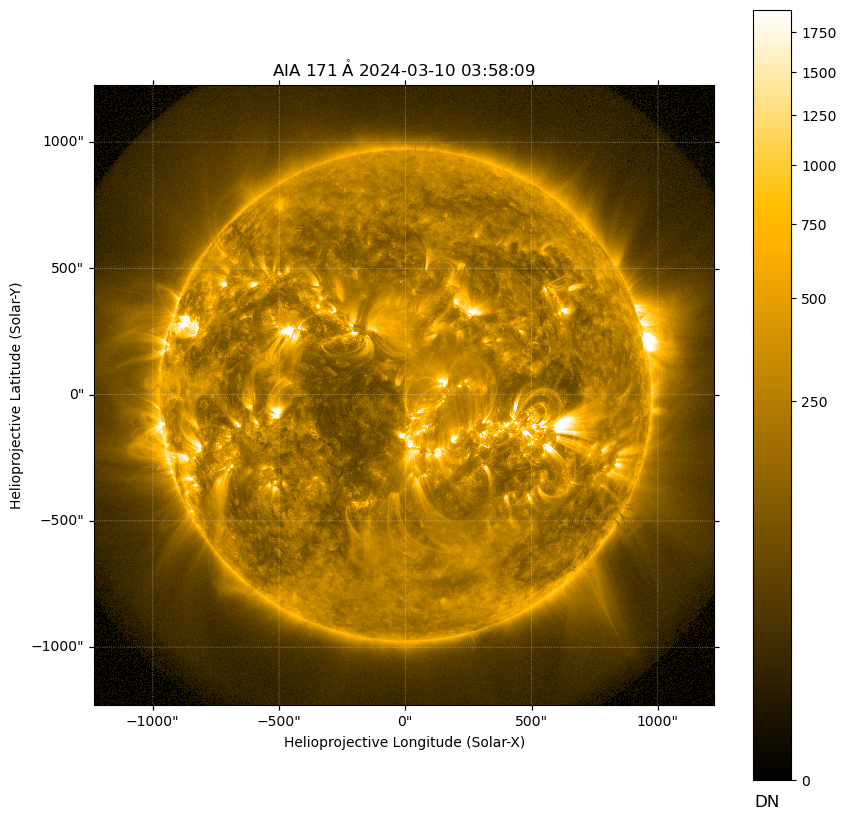

In [37]:
aia_map = aia_sequence[8]
# aia_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=2000, stretch=SqrtStretch())
aia_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=np.nanpercentile(aia_map.data,99.8), stretch=PowerStretch(0.35))
aia_map.peek()

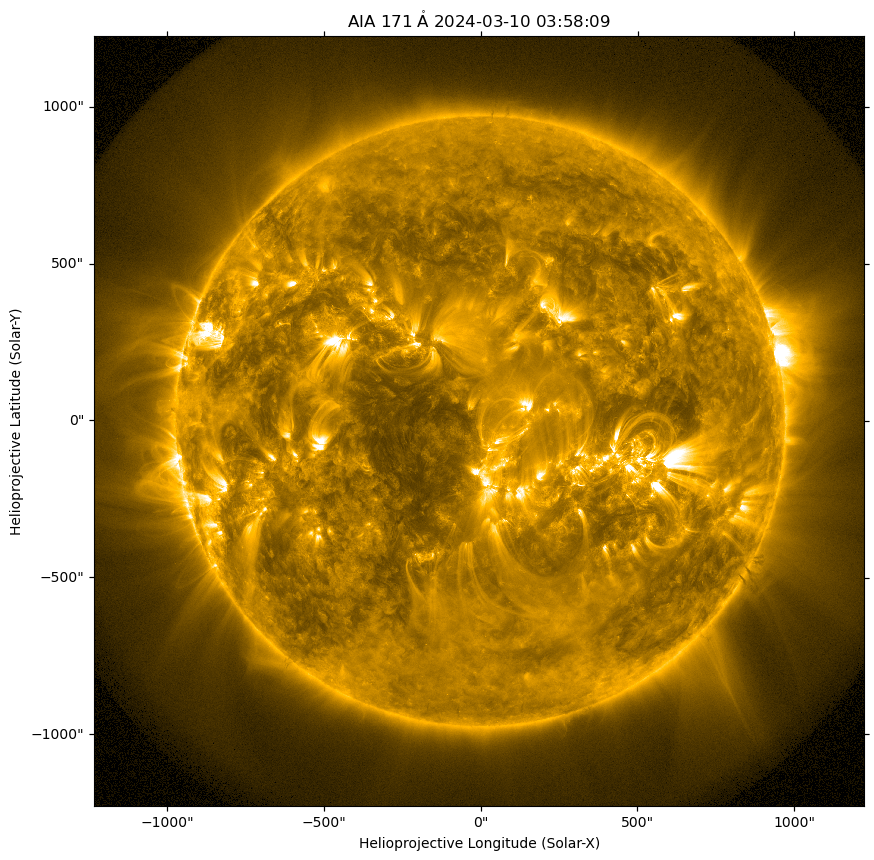

In [64]:
# Plot them together
fig, ax = plt.subplots(subplot_kw={'projection': aia_map})
aia_map.plot(axes=ax)
ax.grid(False)
plt.show()

2025-07-23 02:50:21 - reproject.common - INFO: Calling _reproject_full in non-dask mode


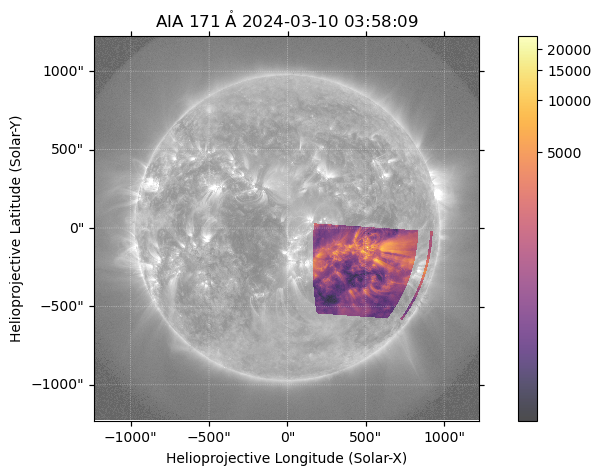

In [365]:
from reproject import reproject_interp

# Reproject EUI map to AIA map’s WCS and shape
eui_data_reprojected, _ = reproject_interp(eui_map, aia_map.wcs, aia_map.data.shape)

# Make new map with reprojected data but using AIA header
eui_reprojected_map = sunpy.map.Map(eui_data_reprojected, aia_map.meta)

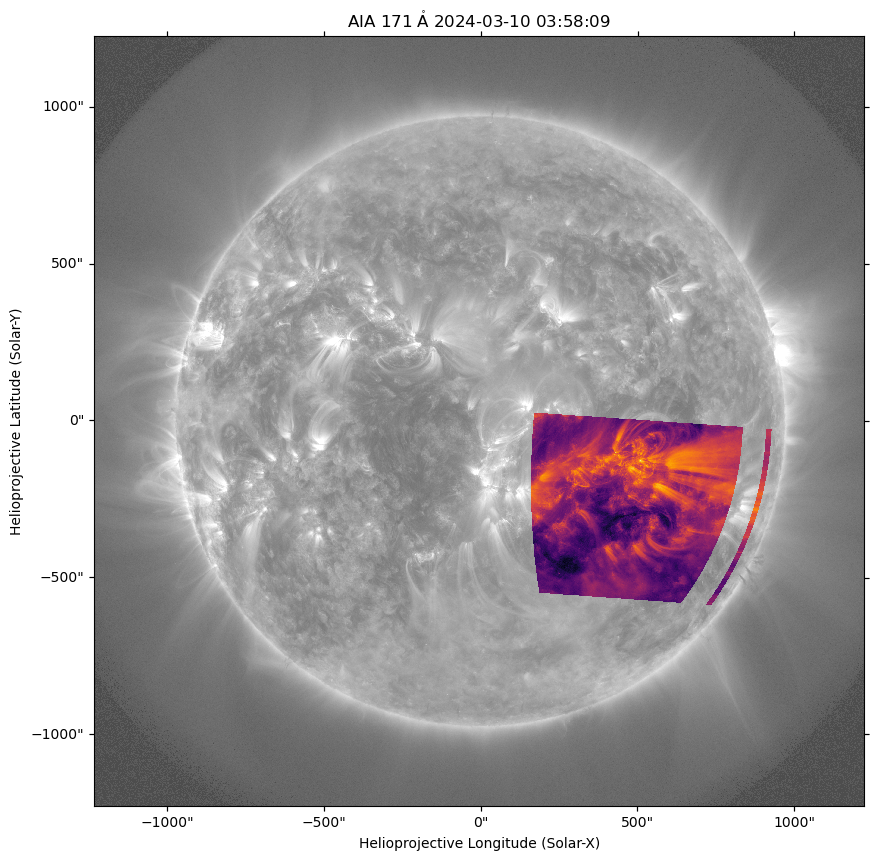

In [382]:
# Plot them together
fig, ax = plt.subplots(subplot_kw={'projection': aia_map})
aia_map.plot(axes=ax, alpha=0.7, cmap='gray')  # Background AIA
eui_reprojected_map.plot(axes=ax, cmap='inferno')  # Overlaid EUI
ax.grid(False)
plt.show()

2025-07-24 16:46:41 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-07-24 16:47:45 - sunpy - WARNING: SunpyUserWarning: rsun mismatch detected: HRI_EUV 174.0 Angstrom 2024-03-10 03:58:16.rsun_meters=695700000.0 m;  2024-03-10 03:58:09.rsun_meters=696000000.0 m. This might cause unexpected results during reprojection.
2025-07-24 16:47:45 - reproject.common - INFO: Calling _reproject_full in non-dask mode


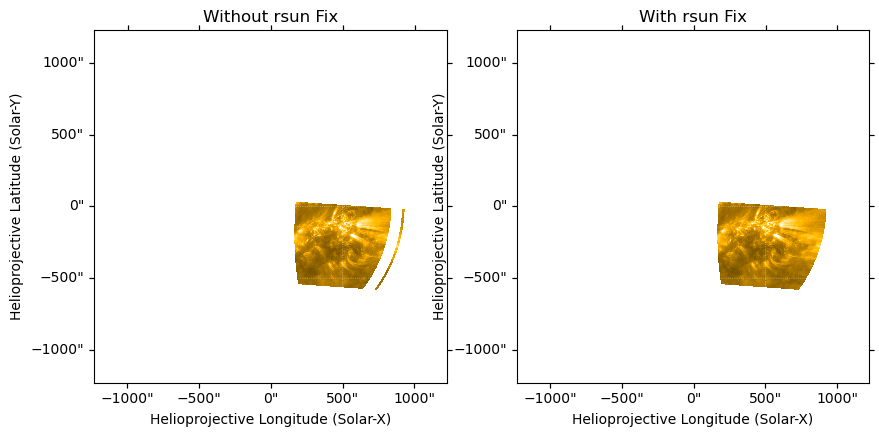

In [67]:
outmap1 = eui_map.reproject_to(aia_map.wcs)
eui_map.meta['rsun_ref'] = aia_map.meta['rsun_ref']
outmap2 = eui_map.reproject_to(aia_map.wcs)

fig = plt.figure()
ax1 = fig.add_subplot(121, projection=outmap1); outmap1.plot(axes=ax1); plt.title('Without rsun Fix')
ax2 = fig.add_subplot(122, projection=outmap2); outmap2.plot(axes=ax2); plt.title('With rsun Fix')

plt.show()

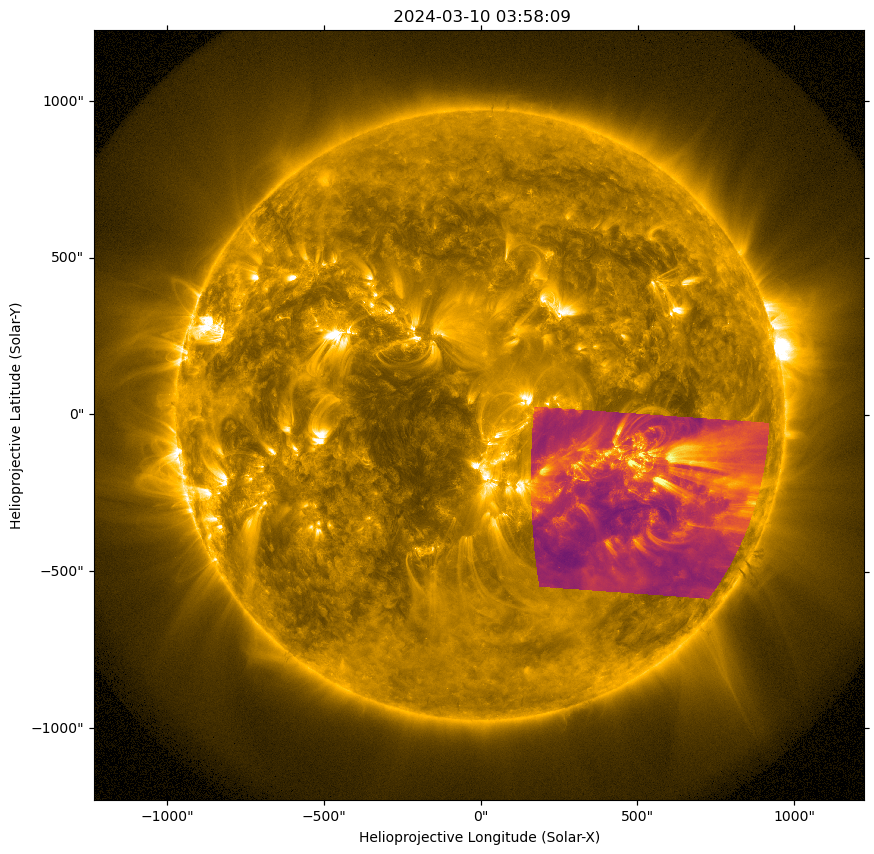

In [69]:
# Plot them together
fig, ax = plt.subplots(subplot_kw={'projection': aia_map})
aia_map.plot(axes=ax, alpha=0.7, cmap='gray')  # Background AIA
outmap2.plot(axes=ax, cmap='inferno')  # Overlaid EUI, With rsun Fix
ax.grid(False)
plt.show()

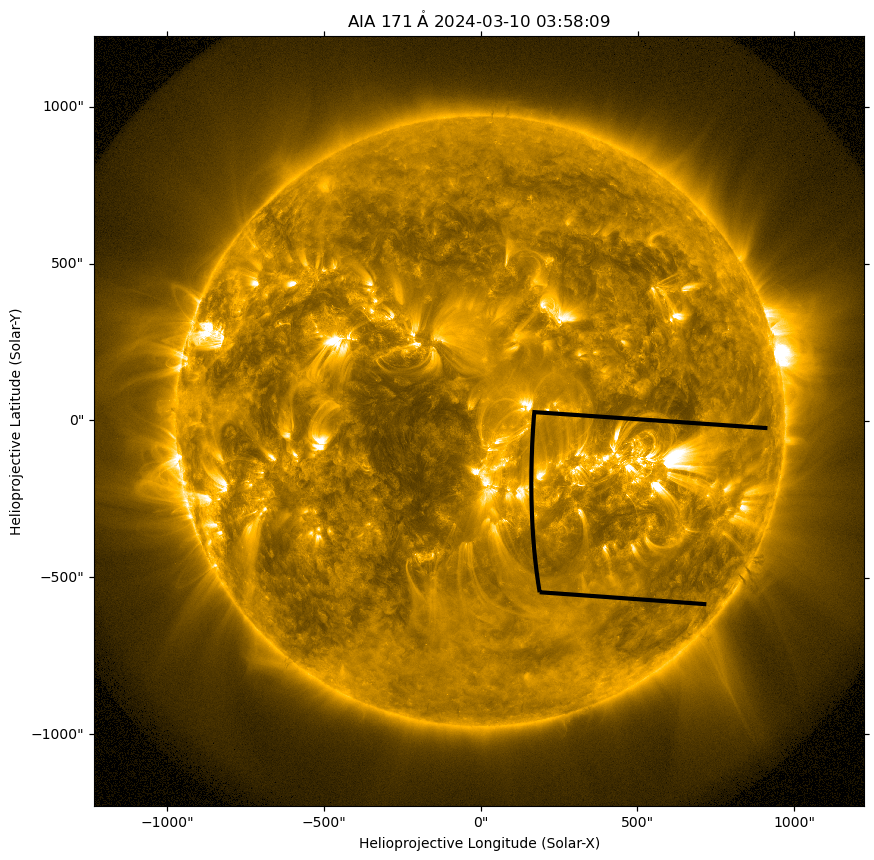

In [47]:
fig, ax = plt.subplots(subplot_kw={'projection': aia_map})
aia_map.plot(axes=ax)
eui_map.draw_extent(axes=ax, color='k', lw=3)
ax.grid(False)
plt.show()

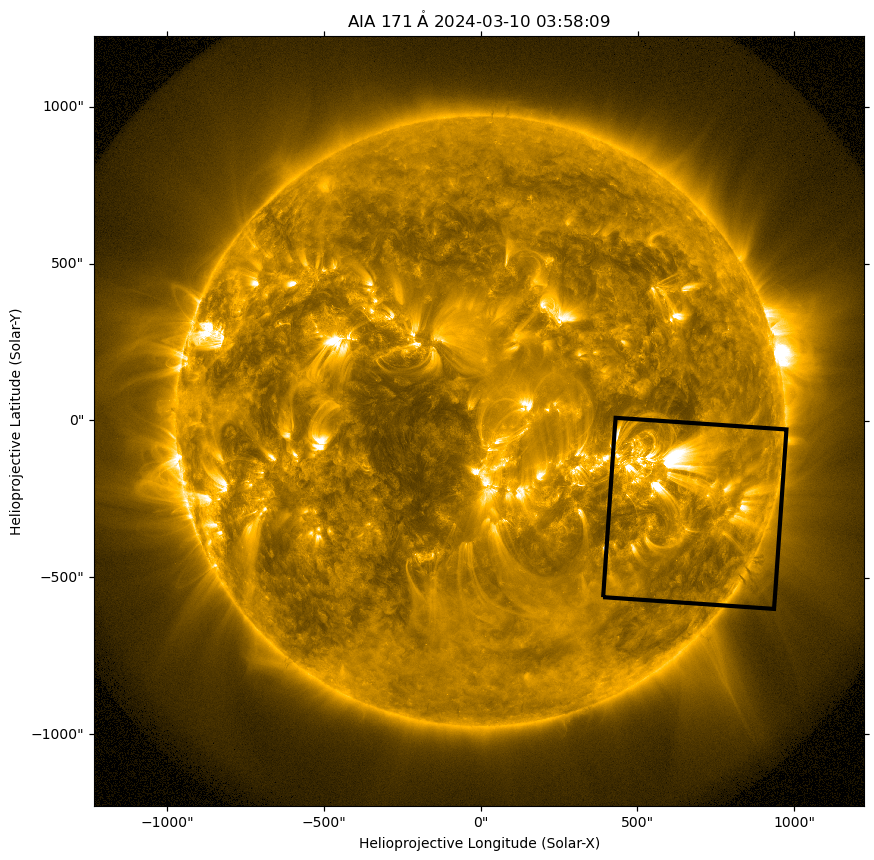

In [61]:
from sunpy.coordinates import SphericalScreen

fig, ax = plt.subplots(subplot_kw={'projection': aia_map})
aia_map.plot(axes=ax)

with SphericalScreen(eui_map.observer_coordinate):
    eui_map.draw_extent(axes=ax, color='k', lw=3)

ax.grid(False)
plt.show()

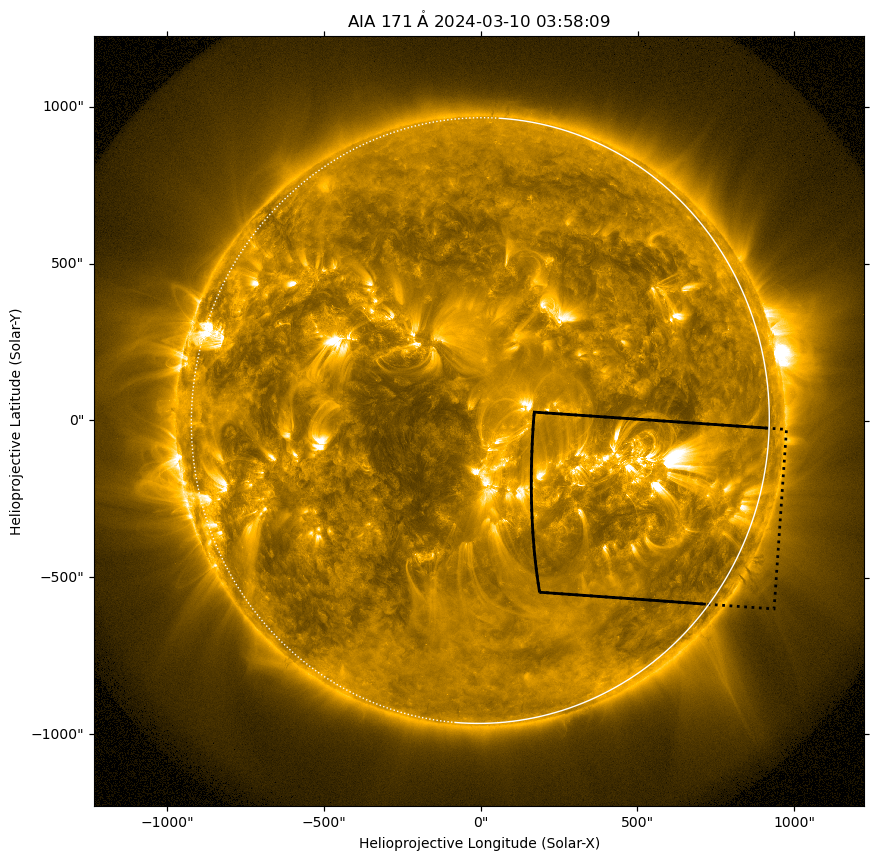

In [72]:
fig, ax = plt.subplots(subplot_kw={'projection': aia_map})
aia_map.plot(axes=ax)

with SphericalScreen(eui_map.observer_coordinate, only_off_disk=True):
    eui_map.draw_extent(axes=ax, color='k', lw=2, ls='dotted')

eui_map.draw_extent(axes=ax, color='k', lw=2)

eui_map.draw_limb()

ax.grid(False)
plt.show()

---

From: https://github.com/SolarOrbiterWorkshop/solo8_tutorials/blob/main/EUI_tutorial/1_introduction.ipynb 

In [ ]:
"""
eui-fsi174-image
eui-fsi304-image
eui-hrilya1216-image
eui-hrieuv174-image
eui-hrieuvnon-image
"""

In [195]:


start_time = '2024-08-09 11:00:00'
end_time   = '2024-08-09 14:00:00'

instrument = a.Instrument('EUI')
level      = a.Level(2)
time       = a.Time(start_time, end_time)

In [196]:
# HRI LYA
product = a.soar.Product('EUI-HRILYA1216-IMAGE')
result  = Fido.search(instrument & time & level & product)
display(result)

<sunpy.net.fido_factory.UnifiedResponse object at 0x73b4c0277c70>
Results from 1 Provider:

0 Results from the SOARClient:

Instrument Data product Level Start time End time Filesize SOOP Name
                                                   Mbyte            
---------- ------------ ----- ---------- -------- -------- ---------

In [197]:
level = a.Level(2)
product = a.soar.Product('EUI-HRIEUV174-IMAGE')
result = Fido.search(instrument & time & level & product)
display(result)

<sunpy.net.fido_factory.UnifiedResponse object at 0x73b4b9e227a0>
Results from 1 Provider:

0 Results from the SOARClient:

Instrument Data product Level Start time End time Filesize SOOP Name
                                                   Mbyte            
---------- ------------ ----- ---------- -------- -------- ---------

In [198]:
# FSI
product = a.soar.Product('EUI-FSI174-IMAGE')
result  = Fido.search(instrument & time & level & product)
display(result)

<sunpy.net.fido_factory.UnifiedResponse object at 0x73b4c0274280>
Results from 1 Provider:

18 Results from the SOARClient:

Instrument   Data product   Level ... Filesize             SOOP Name            
                                  ...  Mbyte                                    
---------- ---------------- ----- ... -------- ---------------------------------
       EUI eui-fsi174-image    L2 ...    3.286 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...    3.131 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...      3.2 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...    3.182 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...    3.237 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...    3.217 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...    3.254 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...    3.099 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...    3.116 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...     3.22 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...      3.2 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...    3.122 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...    3.044 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...    3.125 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...    3.136 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...    3.041 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...    3.228 R_FULL_LRES_LCAD_RS-Synoptics-Low
       EUI eui-fsi174-image    L2 ...    3.205 R_FULL_LRES_LCAD_RS-Synoptics-Low

In [199]:
files = Fido.fetch(result, path='/home/mnedal/data/SOLO/EUI/')

Files Downloaded:   0%|          | 0/18 [00:00<?, ?file/s]

solo_L2_eui-fsi174-image_20240809T110045335_V01.fits:   0%|          | 0.00/3.29M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T112045337_V01.fits:   0%|          | 0.00/3.20M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T113045338_V01.fits:   0%|          | 0.00/3.18M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T114045339_V01.fits:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T111045336_V01.fits:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T115045340_V01.fits:   0%|          | 0.00/3.22M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T120045222_V01.fits:   0%|          | 0.00/3.25M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T121045223_V01.fits:   0%|          | 0.00/3.10M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T122045224_V01.fits:   0%|          | 0.00/3.12M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T123045226_V01.fits:   0%|          | 0.00/3.22M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T124045227_V01.fits:   0%|          | 0.00/3.20M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T125045227_V01.fits:   0%|          | 0.00/3.12M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T130045229_V01.fits:   0%|          | 0.00/3.04M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T131045230_V01.fits:   0%|          | 0.00/3.12M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T132045231_V01.fits:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T133045232_V01.fits:   0%|          | 0.00/3.04M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T134045233_V01.fits:   0%|          | 0.00/3.23M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20240809T135045234_V01.fits:   0%|          | 0.00/3.21M [00:00<?, ?B/s]

In [200]:
sequence = sunpy.map.Map(files, sequence=True)
print(len(sequence))

18


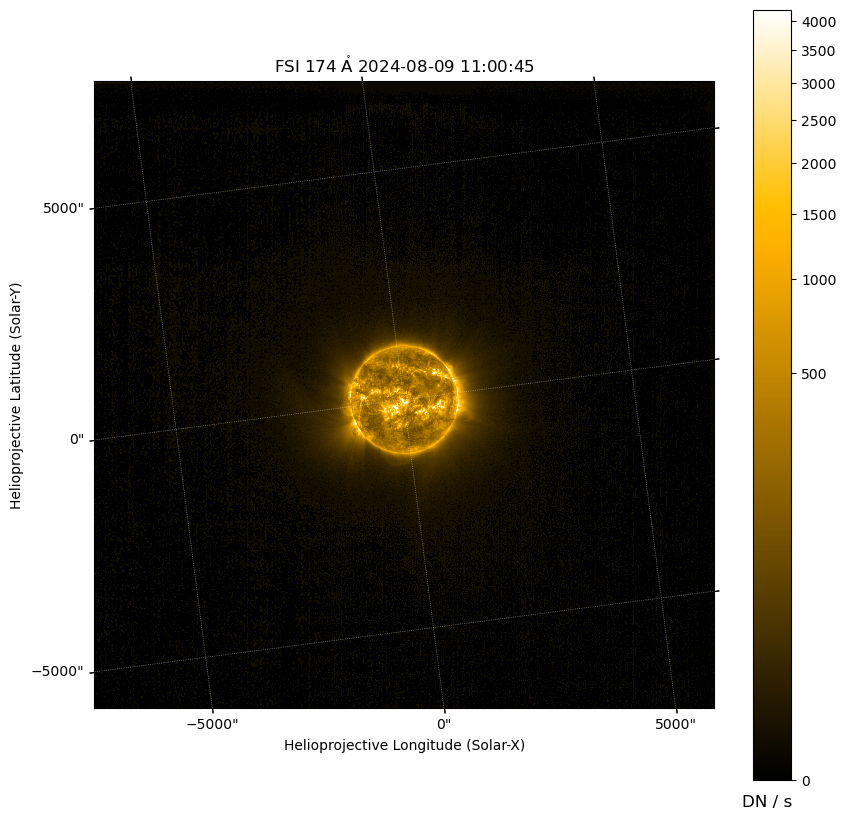

In [201]:
eui_map = sequence[0]
eui_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=np.percentile(each_map.data,99.98), stretch=PowerStretch(0.3))
eui_map.peek()

In [202]:
for each_map in sequence:
    each_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=np.percentile(each_map.data,99.98), stretch=PowerStretch(0.3))

In [203]:
index = {'i': 0}
out = widgets.Output()

def show_map(i):
    with out:
        clear_output(wait=True)
        fig = plt.figure()
        ax = fig.add_subplot(projection=sequence[i])
        sequence[i].plot(axes=ax)
        ax.grid(False)
        display(fig)
        plt.close(fig)  # Prevent ghost plots outside the widget

# Navigation buttons
btn_first = widgets.Button(description='⏮ First')
btn_prev = widgets.Button(description='⬅ Previous')
btn_next = widgets.Button(description='Next ➡')
btn_last = widgets.Button(description='Last ⏭')

# Button logic
def go_first(b): index['i'] = 0; show_map(index['i'])
def go_prev(b): index['i'] = max(0, index['i'] - 1); show_map(index['i'])
def go_next(b): index['i'] = min(len(sequence) - 1, index['i'] + 1); show_map(index['i'])
def go_last(b): index['i'] = len(sequence) - 1; show_map(index['i'])

# Connect buttons
btn_first.on_click(go_first)
btn_prev.on_click(go_prev)
btn_next.on_click(go_next)
btn_last.on_click(go_last)

# Layout
controls = widgets.HBox([btn_first, btn_prev, btn_next, btn_last])
display(controls, out)
show_map(index['i'])

Output()

In [167]:
# submap
index = {'i': 0}
out = widgets.Output()

def show_map(i):
    with out:
        eui_map = sequence[i]
        top_right = SkyCoord(500 * u.arcsec, 1000 * u.arcsec, frame=eui_map.coordinate_frame)
        bottom_left = SkyCoord(-3000 * u.arcsec, -1000 * u.arcsec, frame=eui_map.coordinate_frame)
        submap = eui_map.submap(bottom_left, top_right=top_right)
        
        clear_output(wait=True)
        fig = plt.figure()
        ax = fig.add_subplot(projection=submap)
        submap.plot(axes=ax)
        ax.grid(False)
        display(fig)
        plt.close(fig)  # Prevent ghost plots outside the widget

# Navigation buttons
btn_first = widgets.Button(description='⏮ First')
btn_prev = widgets.Button(description='⬅ Previous')
btn_next = widgets.Button(description='Next ➡')
btn_last = widgets.Button(description='Last ⏭')

# Button logic
def go_first(b): index['i'] = 0; show_map(index['i'])
def go_prev(b): index['i'] = max(0, index['i'] - 1); show_map(index['i'])
def go_next(b): index['i'] = min(len(sequence) - 1, index['i'] + 1); show_map(index['i'])
def go_last(b): index['i'] = len(sequence) - 1; show_map(index['i'])

# Connect buttons
btn_first.on_click(go_first)
btn_prev.on_click(go_prev)
btn_next.on_click(go_next)
btn_last.on_click(go_last)

# Layout
controls = widgets.HBox([btn_first, btn_prev, btn_next, btn_last])
display(controls, out)
show_map(index['i'])

Output()

In [168]:
# apply running difference
assert len(sequence) > 6, 'Need at least 6 images for running difference!'

running_diff_maps = []
with tqdm(total=len(sequence), desc='Applying running difference ...') as pbar:
    for i in range(5, len(sequence)):
        m0 = sequence[i-5]
        m1 = sequence[i]
        diff = m1.quantity - m0.quantity
        smoothed = ndimage.gaussian_filter(diff, sigma=[3,3])
        diff_map = sunpy.map.Map(smoothed, m1.meta)
        diff_map.plot_settings['norm'] = colors.Normalize(vmin=-50, vmax=50)
        running_diff_maps.append(diff_map)
        pbar.update(1)

Applying running difference ...:  38%|██████████████████████████████████████████████▏                                                                            | 3/8 [00:01<00:02,  1.86it/s]


In [129]:
# apply running difference
assert len(sequence) > 6, 'Need at least 6 images for running difference!'

running_diff_maps = []
with tqdm(total=len(sequence), desc='Applying running difference ...') as pbar:
    for i in range(2, len(sequence)):
        m0 = sequence[i-2]
        m1 = sequence[i]
        diff = m1.quantity - m0.quantity
        smoothed = ndimage.gaussian_filter(diff, sigma=[2,2])
        diff_map = sunpy.map.Map(smoothed, m1.meta)
        diff_map.plot_settings['norm'] = colors.Normalize(vmin=-50, vmax=50)
        running_diff_maps.append(diff_map)
        pbar.update(1)

Applying running difference ...:  75%|████████████████████████████████████████████████████████████████████████████████████████████▎                              | 6/8 [00:02<00:00,  2.50it/s]


In [105]:
# def apply_rundiff(maps):
#     """
#     Apply running-diff image technique on EUV images.
#         Inputs:
#             - list of EUV sunpy maps.
#             - range of the clipping threshold.
#         Output:
#             - sequence of run-ratio sunpy maps.
#     """
#     rundiff = []
#     with tqdm(total=len(maps), desc='Applying running diff ...') as pbar:
#         for i in range(1, len(maps)):
#             m = maps[i]
#             prev_m = maps[i - 1]
#             diff = m - prev_m.quantity
#             # diff.data[np.isnan(ratio.data)] = 1
#             diff.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=2, stretch=PowerStretch(0.9))
#             rundiff.append(diff)
#             pbar.update(1)
#     m_seq_rundiff = sunpy.map.Map(rundiff, sequence=True)
#     return m_seq_rundiff


# running_diff_maps = apply_rundiff(sequence)

In [169]:
# Run-diff maps
index = {'i': 0}
out = widgets.Output()

def show_map(i):
    with out:
        eui_map = running_diff_maps[i]
        top_right = SkyCoord(500 * u.arcsec, 1000 * u.arcsec, frame=eui_map.coordinate_frame)
        bottom_left = SkyCoord(-3000 * u.arcsec, -1000 * u.arcsec, frame=eui_map.coordinate_frame)
        submap = eui_map.submap(bottom_left, top_right=top_right)
        
        clear_output(wait=True)
        fig = plt.figure()
        ax = fig.add_subplot(projection=submap)
        submap.plot(axes=ax)
        ax.grid(False)
        display(fig)
        plt.close(fig)  # Prevent ghost plots outside the widget

# Navigation buttons
btn_first = widgets.Button(description='⏮ First')
btn_prev = widgets.Button(description='⬅ Previous')
btn_next = widgets.Button(description='Next ➡')
btn_last = widgets.Button(description='Last ⏭')

# Button logic
def go_first(b): index['i'] = 0; show_map(index['i'])
def go_prev(b): index['i'] = max(0, index['i'] - 1); show_map(index['i'])
def go_next(b): index['i'] = min(len(sequence) - 1, index['i'] + 1); show_map(index['i'])
def go_last(b): index['i'] = len(sequence) - 1; show_map(index['i'])

# Connect buttons
btn_first.on_click(go_first)
btn_prev.on_click(go_prev)
btn_next.on_click(go_next)
btn_last.on_click(go_last)

# Layout
controls = widgets.HBox([btn_first, btn_prev, btn_next, btn_last])
display(controls, out)
show_map(index['i'])

Output()

In [ ]:
product = a.soar.Product('EUI-FSI304-IMAGE')
result  = Fido.search(instrument & time & level & product)
print(result)

In [ ]:
files = Fido.fetch(result, path='/home/mnedal/data/SOLO/EUI/')

In [ ]:
sequence = sunpy.map.Map(files, sequence=True)
for each_map in sequence:
    each_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=500, stretch=PowerStretch(0.3))

plt.figure()
ani = sequence.plot(interval=500)
plt.grid(False)
plt.colorbar(shrink=0.8)
plt.show()

In [ ]:
fsi304 = sequence[0]
fsi304.plot()

top_right = SkyCoord(2500 * u.arcsec, 0 * u.arcsec, frame=fsi304.coordinate_frame)
bottom_left = SkyCoord(0 * u.arcsec, -2500 * u.arcsec, frame=fsi304.coordinate_frame)
fsi304_submap = fsi304.submap(bottom_left, top_right=top_right)

fig = plt.figure()
ax  = fig.add_subplot(projection=fsi304_submap)
fsi304_submap.plot(axes=ax)
ax.grid(False)
plt.show()

In [ ]:

"""
==================================
Finding and Plotting EUI Data
==================================

This example demonstrates how to search for, download, and plot 
Solar Orbiter EUI (Extreme Ultraviolet Imager) observations using SunPy.

"""

import matplotlib.pyplot as plt
import sunpy.map
from sunpy.net import Fido, attrs as a
import sunpy_soar

###############################################################################
# Registering the Solar Orbiter Archive (SOAR)
# --------------------------------------------
#
# By importing `sunpy_soar`, the Solar Orbiter Archive (SOAR) is **automatically**
# registered as a data provider in `Fido`. This allows us to directly query and 
# download Solar Orbiter data just like any other SunPy Fido search.
#
# Now, we will use `Fido` to search for available EUI Full Sun Imager (FSI) 174 angstrom data, namely
# the dataproduct called **EUI-FSI174-IMAGE**, within a specific time range.
#
# The search will return metadata about available files.

search_results = Fido.search(a.Time("2024-09-14 14:00", "2024-09-14 20:00"),
                             a.soar.Product("EUI-FSI174-IMAGE"),
                             a.Level(2))

print(search_results)

###############################################################################
# Fetching the First Available File
# ---------------------------------
#
# The search results contain a list of available files matching our query.
# We can use `Fido.fetch` to download the first available file.

downloaded_files = Fido.fetch(search_results[0, 0])

###############################################################################
# Visualizing the EUI Image with `sunpy.map`
# -------------------------------------------
#
# The downloaded file is in **FITS format**, which is commonly used for astronomical
# imaging data. We use `sunpy.map.Map` to load and display it.

eui_map = sunpy.map.Map(downloaded_files[0])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection=eui_map)
eui_map.plot(axes=ax)
plt.colorbar()
plt.title("Solar Orbiter EUI Image")
plt.show()